In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "/content/gdrive/MyDrive/deep_learning_project/"
!pip install import-ipynb

/content/gdrive/MyDrive/deep_learning_project


# IMAGE LOADING AND DATASET SAVING

importing Jupyter notebook from utils.ipynb


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


------------------------------------------------
original distribution


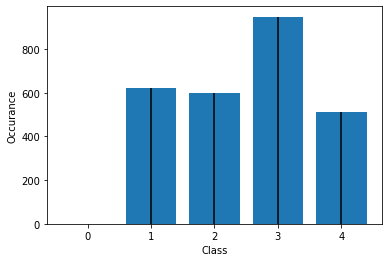

------------------------------------------------
testing set


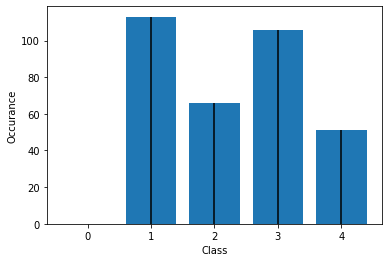

(2676, 150, 150)


In [3]:
import import_ipynb
from utils import *
from PIL import Image, ImageEnhance
import tensorflow as tf
from sklearn.utils import shuffle


training_images, training_labels = load_training()
testing_images, testing_labels = load_testing()
labels_distribution(training_labels,"original distribution")
labels_distribution(testing_labels,"testing set")

print(np.shape(training_images))

------------------------------------------------
traducted distribution


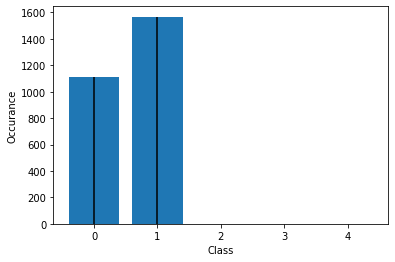

------------------------------------------------
testing set


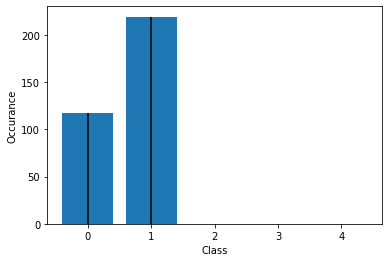

(2676, 150, 150)


In [4]:
training_labels = label_traduction(training_labels,0)
testing_labels = label_traduction(testing_labels,0)
labels_distribution(training_labels,"traducted distribution")
labels_distribution(testing_labels,"testing set")
print(np.shape(training_images))

Oversampling on label 0
------------------------------------------------
oversampled distribution


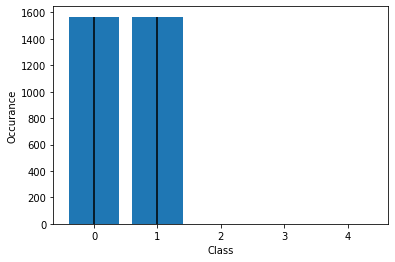

In [5]:
training_images, training_labels = oversample(training_images,training_labels)
#training_images, training_labels = gan_oversample(training_images,training_labels,0)
labels_distribution(training_labels,"oversampled distribution")


------------------------------------------------
oversampled distribution shuffled


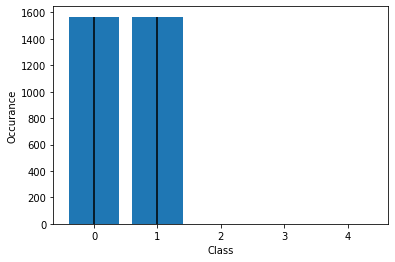

In [6]:
training_images,training_labels = shuffle_data(training_images,training_labels)
labels_distribution(training_labels,"oversampled distribution shuffled")

In [7]:
training_images = enhance_contrast(training_images)
testing_images = enhance_contrast(testing_images)
#training_images = enhance_image(training_images)
#testing_images = enhance_image(testing_images)

In [8]:
'''
training_images = filter_dataset(training_images)
testing_images = filter_dataset(testing_images)

visualize_image(training_images[0],"")
'''

'\ntraining_images = filter_dataset(training_images)\ntesting_images = filter_dataset(testing_images)\n\nvisualize_image(training_images[0],"")\n'

# Dataset importing

In [9]:
import tensorflow as tf
TRAIN_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/train"
TEST_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/test"
BATCH_SIZE = 32
NORMALIZATION = 65536

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./NORMALIZATION)

'''
train_datagen = ImageDataGenerator(
    rescale=1./NORMALIZATION,
    #rotation_range=40,
    rotation_range=90,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=20,
    #zoom_range=0.2,
    #horizontal_flip=True,
    )
'''

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION)

#training_images =  np.array(training_images)
#testing_images =  np.array(testing_images)

training_images = np.expand_dims(training_images, -1)
testing_images = np.expand_dims(testing_images, -1)

splitted_train_images, splitted_val_images, splitted_train_labels, splitted_val_labels = train_test_split(training_images, training_labels, test_size=0.3, stratify=training_labels)


train_generator = train_datagen.flow(splitted_train_images, 
                                     y=splitted_train_labels, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)

validation_generator = train_datagen.flow(splitted_val_images, 
                                          y=splitted_val_labels, 
                                          batch_size=BATCH_SIZE, 
                                          seed=123)

test_generator =  test_datagen.flow(testing_images,
                                    y=testing_labels,
                                    batch_size=BATCH_SIZE,
                                    seed=123)

# CNN Model Construction

# Model Compile

In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import models,layers

conv_base = InceptionV3(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(150, 150, 3),
                )

conv_base.trainable=False

conv_base = models.Model(inputs=conv_base.input, outputs=conv_base.get_layer('mixed9').output)
#conv_base = Model(inputs=conv_base.input, outputs=conv_base.get_layer('mixed8').output)
conv_base.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model = models.Sequential()
model.add(tf.keras.Input(shape=(150,150,1)))
model.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123))
model.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest'))
model.add(layers.Conv2D(3,(1,1),activation = 'relu')) # to transform grayscale to rgb images
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 150, 150, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 150, 150, 3)       6         
_________________________________________________________________
model (Functional)           (None, 3, 3, 2048)        15722720  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9

In [13]:
import tensorflow as tf
from tensorflow.keras import optimizers


model.compile(loss='binary_crossentropy',
              #optimizer='adam',
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Model Fitting

In [14]:
EPOCHS = 15

history = model.fit(
    train_generator, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = validation_generator,
    )

Epoch 1/15
69/69 [==============================] - 29s 299ms/step - loss: 1.0946 - accuracy: 0.6123 - val_loss: 1.0072 - val_accuracy: 0.5335
Epoch 2/15
69/69 [==============================] - 17s 249ms/step - loss: 0.6519 - accuracy: 0.6510 - val_loss: 0.9595 - val_accuracy: 0.5356
Epoch 3/15
69/69 [==============================] - 17s 249ms/step - loss: 0.6270 - accuracy: 0.6733 - val_loss: 0.6174 - val_accuracy: 0.6504
Epoch 4/15
69/69 [==============================] - 17s 248ms/step - loss: 0.5786 - accuracy: 0.6893 - val_loss: 0.5734 - val_accuracy: 0.7333
Epoch 5/15
69/69 [==============================] - 17s 249ms/step - loss: 0.5697 - accuracy: 0.7043 - val_loss: 0.5621 - val_accuracy: 0.7439
Epoch 6/15
69/69 [==============================] - 17s 250ms/step - loss: 0.5484 - accuracy: 0.7148 - val_loss: 0.7223 - val_accuracy: 0.6174
Epoch 7/15
69/69 [==============================] - 17s 248ms/step - loss: 0.5566 - accuracy: 0.7212 - val_loss: 0.6080 - val_accuracy: 0.6908

#Model Saving

In [19]:

import pickle

path = "/content/gdrive/MyDrive/deep_learning_project/models/3.2/"
model_name = "InceptionV3"

model.save( path + model_name + ".h5")

with open(path + model_name + "_history.pickle", 'wb') as file_pi:
        pickle.dump(history.history,  file_pi)


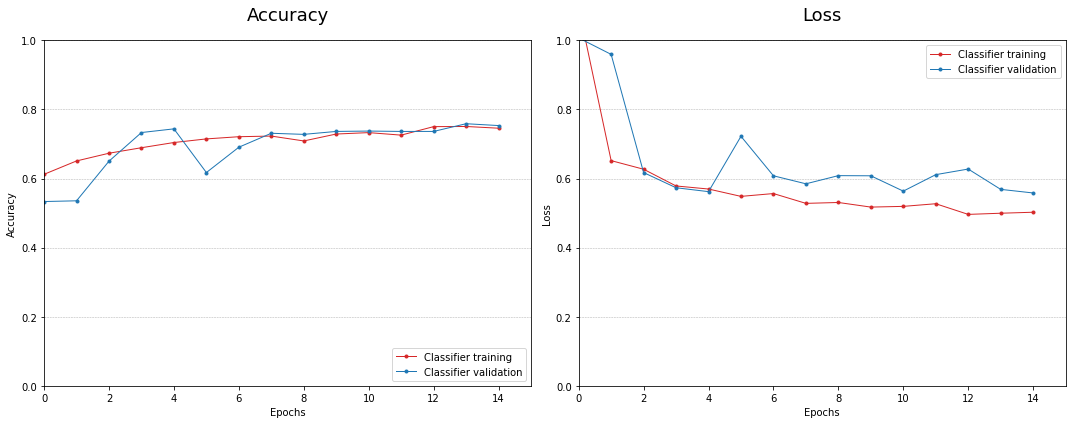

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))

# plot accuracy curves
acc_g.plot(epochs, acc, color='tab:red', marker='.', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)
acc_g.axis([0,15,0,1])

# plot loss curves
loss_g.plot(epochs, loss, color='tab:red', marker='.', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)
loss_g.axis([0,15,0,1])

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

11/11 [==============================] - 2s 152ms/step - loss: 0.5855 - accuracy: 0.6964
Test loss 0.5854912400245667
Test accuracy 0.6964285969734192


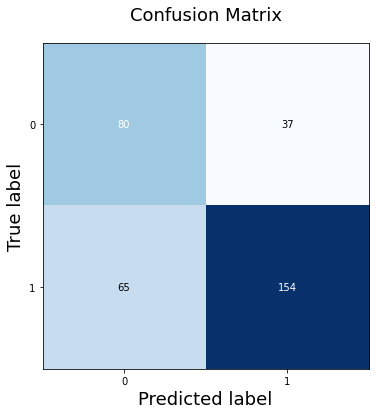

precision score:  0.806282722513089
recall score:  0.7031963470319634
f2:  0.7216494845360826
f0.5:  0.7833163784333673
classification report: 
               precision    recall  f1-score   support

           0       0.55      0.68      0.61       117
           1       0.81      0.70      0.75       219

    accuracy                           0.70       336
   macro avg       0.68      0.69      0.68       336
weighted avg       0.72      0.70      0.70       336

AUC:  0.6934785153963235


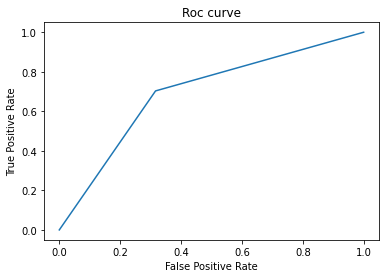

In [18]:
prediction = model.predict(testing_images/65536)
in_depth_performance(testing_labels,np.where(prediction > 0.5, 1,0)) #np.where is used to conver from probability to binary label